In [4]:
from typing import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")

import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce

In [10]:
# Flatten the images into a vector
flatten = lambda x: ToTensor()(x).view(28**2)
transform = lambda x: ToTensor()(x) *2 - 1

# Define the train and test sets
dset_train = MNIST("./", train=True,  transform=transform, download=True)
dset_test  = MNIST("./", train=False, transform=transform)

# The digit classes to use
#classes = [3, 7]
#classes = [1, 4, 9, 0]
# classes = [3, 5, 8, 1]
classes = [i for i in range(10)]

def stratified_sampler(labels):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)


batch_size = 64
eval_batch_size = 100
# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.targets))
test_loader  = DataLoader(dset_test, batch_size=eval_batch_size, 
                          sampler=stratified_sampler(dset_test.targets))


dtype: torch.float32
N x C x H x W: torch.Size([64, 1, 28, 28])


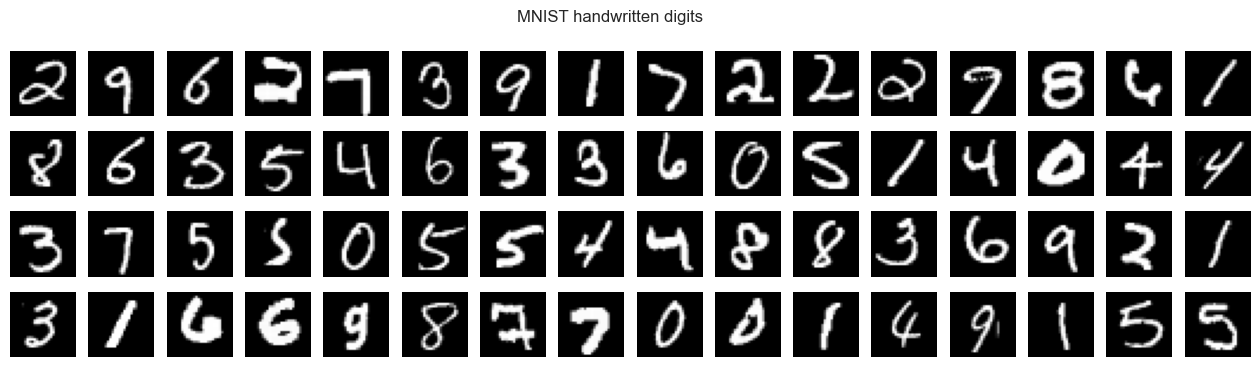

In [12]:
#plot a few MNIST examples
f, axarr = plt.subplots(4, 16, figsize=(16, 4))

# Load a batch of images into memory
images, labels = next(iter(train_loader))
print(f"dtype: {images.dtype}")

print(f"N x C x H x W: {images.shape}")

for i, ax in enumerate(axarr.flat):
    #ax.imshow(images[i].view(28, 28), cmap="binary_r")
    ax.imshow(images[i,0,:,:], cmap="binary_r")
    ax.axis('off')
    
plt.suptitle('MNIST handwritten digits')
plt.show()

U-net given by Jes in the slack channel:

In [44]:
class ScoreNetwork0(torch.nn.Module):
    # takes an input image and time, returns the score function
    def __init__(self):
        super().__init__()
        nch = 1
        chs = [32, 64, 128, 256, 256]
        self._convs = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Conv2d(nch, chs[0], kernel_size=3, padding=1),  # (batch, ch, 28, 28)
                torch.nn.LogSigmoid(),  # (batch, 8, 28, 28)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 14, 14)
                torch.nn.Conv2d(chs[0], chs[1], kernel_size=3, padding=1),  # (batch, ch, 14, 14)
                torch.nn.LogSigmoid(),  # (batch, 16, 14, 14)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 7, 7)
                torch.nn.Conv2d(chs[1], chs[2], kernel_size=3, padding=1),  # (batch, ch, 7, 7)
                torch.nn.LogSigmoid(),  # (batch, 32, 7, 7)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # (batch, ch, 4, 4)
                torch.nn.Conv2d(chs[2], chs[3], kernel_size=3, padding=1),  # (batch, ch, 4, 4)
                torch.nn.LogSigmoid(),  # (batch, 64, 4, 4)
            ),
            torch.nn.Sequential(
                torch.nn.MaxPool2d(kernel_size=2, stride=2),  # (batch, ch, 2, 2)
                torch.nn.Conv2d(chs[3], chs[4], kernel_size=3, padding=1),  # (batch, ch, 2, 2)
                torch.nn.LogSigmoid(),  # (batch, 64, 2, 2)
            ),
        ])
        self._tconvs = torch.nn.ModuleList([
            torch.nn.Sequential(
                # input is the output of convs[4]
                torch.nn.ConvTranspose2d(chs[4], chs[3], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, 64, 4, 4)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[3]
                torch.nn.ConvTranspose2d(chs[3] * 2, chs[2], kernel_size=3, stride=2, padding=1, output_padding=0),  # (batch, 32, 7, 7)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[2]
                torch.nn.ConvTranspose2d(chs[2] * 2, chs[1], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, chs[2], 14, 14)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[1]
                torch.nn.ConvTranspose2d(chs[1] * 2, chs[0], kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, chs[1], 28, 28)
                torch.nn.LogSigmoid(),
            ),
            torch.nn.Sequential(
                # input is the output from the above sequential concated with the output from convs[0]
                torch.nn.Conv2d(chs[0] * 2, chs[0], kernel_size=3, padding=1),  # (batch, chs[0], 28, 28)
                torch.nn.LogSigmoid(),
                torch.nn.Conv2d(chs[0], 1, kernel_size=3, padding=1),  # (batch, 1, 28, 28)
            ),
        ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (..., ch0 * 28 * 28), t: (..., 1)
        signal = torch.reshape(x, (x.shape[0], 1, 28, 28)).type(torch.float)  # (..., ch0, 28, 28)
        signals = []
        for i, conv in enumerate(self._convs):
            signal = conv(signal)
            if i < len(self._convs) - 1:
                signals.append(signal)

        for i, tconv in enumerate(self._tconvs):
            if i == 0:
                signal = tconv(signal)
            else:
                signal = torch.cat((signal, signals[-i]), dim=-3)
                signal = tconv(signal)
        signal = torch.reshape(signal, x.shape)  # (..., 1 * 28 * 28)
        return signal


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

score_network = ScoreNetwork0().to(device)

cuda:0


Parameters as chosen by the authors of the paper

In [45]:
beta_min = 10e-4   # Smallest beta to consider
beta_max = 2*10e-2  # Largest beta to consider
T = 1000      # Number of different betas to consider

betas = torch.linspace(beta_min, beta_max, T, dtype=torch.float).to(device)
alphas = (1 - betas).to(device)
alpha_bars = torch.cumprod(alphas, 0).to(device)

In [ ]:
num_epochs = 1000
valid_every = 5
lr = 1e-3

optimizer = torch.optim.Adam(score_network.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()

train_loss = []

for i in range(num_epochs):

    score_network.train()

    t_loss = 0
    for x, y in train_loader:
        x = x.to(device)
        eps = torch.randn_like(x).to(device)
        t = torch.randint(T, (x.shape[0],)).to(device)

        coeffs = alpha_bars[t]
        input = coeffs[:,None,None,None].sqrt()*x + (1-coeffs[:,None,None,None]).sqrt()*eps
        output = score_network(input)

        optimizer.zero_grad()
        loss = loss_fn(output, eps)
        loss.backward()
        optimizer.step()

        t_loss += loss.detach().cpu().numpy()

    train_loss.append(t_loss / len(train_loader))
    if i % valid_every == 0: 
        print(f"Epoch {i}, train loss: {train_loss[-1]}")

Epoch 1, train loss: 0.08436568705801929
Epoch 6, train loss: 0.015763947191878534
Epoch 11, train loss: 0.012733266130635844
Epoch 16, train loss: 0.011299018936379671


Sampling algorithm:

In [ ]:
def sample_image(network, T, N):

    network.eval()
    with torch.no_grad():
        x = torch.randn(N, 1, 28, 28).to(device)

        for t in range(T,0,-1):
            if t > 1:
                z = torch.randn_like(x).to(device)
            else:
                z = torch.zeros_like(x).to(device)
        
            output = network(x)
            
            x = 1/alphas[t-1].sqrt() * (x - (1-alphas[t-1])/(1-alpha_bars[t-1]).sqrt() * output) + betas[t-1].sqrt() * z
            
    #x = torch.clamp(x, 0, 1)

    return x

For saving/loading network params

In [ ]:
#torch.save(score_network.state_dict(), "MNIST_PARAMS.pt")

#score_network = ScoreNetwork0().to(device)
#score_network.load_state_dict(torch.load("MNIST_PARAMS.pt", weights_only=True))

<All keys matched successfully>

Generating samples:

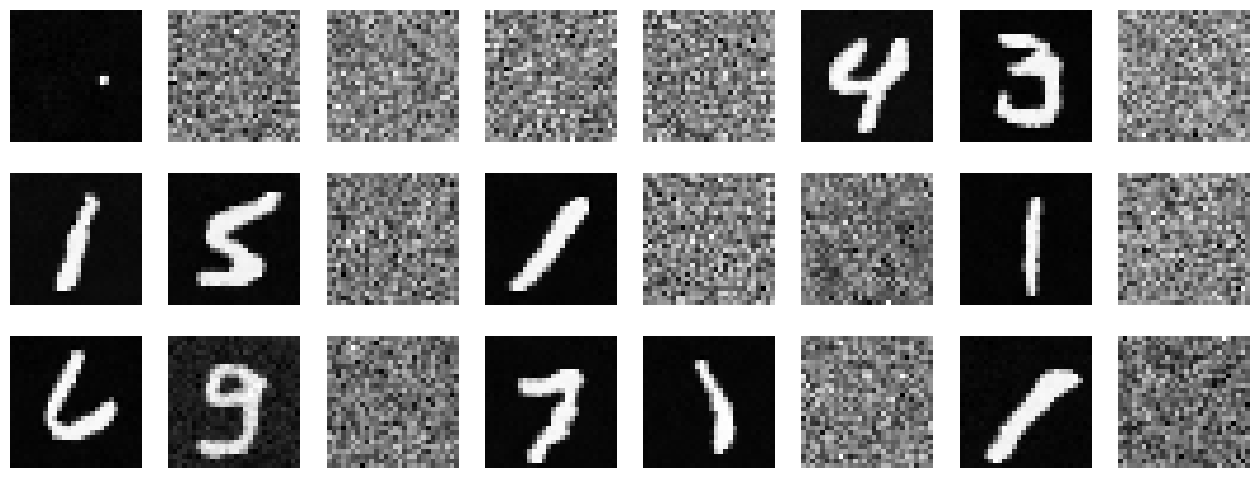

In [48]:
x_sample = sample_image(score_network, T, 24).cpu().numpy().squeeze()

fig, axs = plt.subplots(3, 8, figsize=(16, 6))

for i, ax in enumerate(axs.flat):
    ax.imshow(x_sample[i], cmap="binary_r")
    ax.axis('off')

In [26]:
x_sample.min(), x_sample.max()

(-1.2275542, 1.3390003)